In [3]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load the dataset

In [4]:
# Load the dataset as (image,label) tuples and split in 80% train and 20% test data
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


# Inspect the dataset

In [5]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


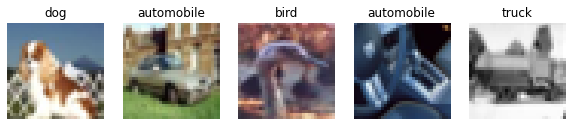

In [6]:
explicit_labels =['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
fig, ax = plt.subplots(1,5,figsize=(10,15))
for index, sample in enumerate(np.random.choice(train_images.shape[0], 5)):
    ax[index].imshow(train_images[sample])
    ax[index].set_title(explicit_labels[train_labels[sample,0]])
    ax[index].axis("off")

# Preprocess the data

In [7]:
# Set input shape for model
my_input_shape = (train_images.shape[1:])

# Create training and test dataset form the images and labels
train_dataset_images = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset_targets = tf.data.Dataset.from_tensor_slices(train_labels)
test_dataset_images = tf.data.Dataset.from_tensor_slices(test_images)
test_dataset_targets = tf.data.Dataset.from_tensor_slices(test_labels)

# Zip images and labels
train_dataset = tf.data.Dataset.zip((train_dataset_images, train_dataset_targets))
test_dataset = tf.data.Dataset.zip((test_dataset_images, test_dataset_targets))

# Normalize images and onehot encode the labels
train_dataset = train_dataset.map(lambda img, lbl: (tf.cast(2*(img/255)-1,tf.float32),
                                                    tf.squeeze(tf.one_hot(lbl, 10))),
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(lambda img, lbl: (tf.cast(2*(img/255)-1,tf.float32),
                                                  tf.squeeze(tf.one_hot(lbl, 10))),
                                num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Cache the preprocessed datasets
train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()

# Shuffle the data
train_dataset = train_dataset.shuffle(64)
test_dataset = test_dataset.shuffle(64)

# Create minibatches
train_dataset = train_dataset.batch(64)
test_dataset = test_dataset.batch(64)

# Prefetch the data
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Define transition layer

We can use this layer to **half our input size** and **reduce or increase the number of input-channels** .  
This is not only needed in our DenseNet but also helpfull when we change the scale in our ResNet.

We inherit from **keras.Model** instead of **keras.layers.Layer** because the **keras.Model** also tracks its internal layers, making them easier to inspect with *Model.summary()*.

In [8]:
from tensorflow.keras import Model, regularizers

class TransitionLayer(Model):
    '''
    Creates a transition layer consisting of one bottleneck layer with batchnormalization and one average pooling layer

            Parameters:
                    channels: The number of channels the output of this layer should have
                    regularizer:The kernel regularizer for the bottleneck layer

            Returns:
                    x: The output of the transition layer
    '''
    def __init__(self, channels, regularizer = None):
        super(TransitionLayer, self).__init__()
        self.my_layers = [
            tf.keras.layers.Conv2D(
                filters=channels,
                kernel_size=1,
                padding='same',
                activation=None,
                kernel_regularizer=regularizer
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            tf.keras.layers.AveragePooling2D()
        ]
        
    def call(self, x, training=False):
        for layer in self.my_layers:
            x = layer(x, training=training)
        return x

### Test the TransitionLayer

We test if the outputshape of our transitional layer matches our expectation

In [9]:
transLayer = TransitionLayer(32)
t = transLayer(tf.zeros([1,32,32,16])) # Inputshape: 32,32,16
t.shape # Outputshape should be 16,16,32

TensorShape([1, 16, 16, 32])

# Define ResidualBlock

In [10]:
from tensorflow.keras import Model, regularizers

class ResidualBlock(Model):
    '''
    Creates a residual block consisting of convolutional layers with batchnormalization
    The output of the residual block is added to it's input

            Parameters:
                    filters: The list containing the number of filters for each convolutional layer in the block 
                    kernel_sizes: The list containing the kernel size for each convolutional layer in the block
                    regularizer:The kernel regularizer for the convolutional layers in the block 
                    dropout_rate: The dropout rate for each convolutional layer in the block

            Returns:
                    x: The output of the residual block added to it's input
    '''
    def __init__(self, filters, kernel_sizes, regularizer = None, dropout_rate = 0):
        super(ResidualBlock, self).__init__()
        self.my_layers = []
        # Add the convolutional layers as specified in the parameters and append Batchnormalzation and ReLU to each
        for my_filter,my_kernel_size in zip(filters, kernel_sizes):       
            self.my_layers.append(
                tf.keras.layers.Conv2D(
                    filters=my_filter,
                    kernel_size=my_kernel_size,
                    padding='same',
                    activation=None,
                    kernel_regularizer=regularizer)
            )                        
            self.my_layers.append(tf.keras.layers.BatchNormalization())
            self.my_layers.append(tf.keras.layers.Dropout(dropout_rate))
            self.my_layers.append(tf.keras.layers.Activation('relu'))
            
        # Remove the last ReLU layer, we want to add the input to our last output before applying the activation
        del self.my_layers[-1]
        
    def call(self, x, training = False):
        my_input = x
        for layer in self.my_layers:
            x = layer(x, training=training)
        x += my_input
        return tf.keras.activations.relu(x)        

### Test the ResidualBlock
Here we test if the ResidualBlock creates the correct layers.  
We simply forwardpass a "black image" through the block to get a summary.

In [11]:
resBlock = ResidualBlock([64,64],[3,3])
_ = resBlock(tf.zeros([1, 32, 32, 64]))
resBlock.summary()

Model: "residual_block"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            multiple                  36928     
_________________________________________________________________
batch_normalization_1 (Batch multiple                  256       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
activation_1 (Activation)    multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  36928     
_________________________________________________________________
batch_normalization_2 (Batch multiple                  256       
_________________________________________________________________
dropout_1 (Dropout)          multiple               

# Define the ResNet model

Here we define our ResNet model. We initialize the model with a list that contains the number of residual block we want to have in a scale (Remember: A scale means a section of the net were the size of the output stays the same) and the number of filters of the first layer in our net.  
Whenever we enter the next scale in the net the number of filters is doubled while the output size is halved using transition layer between the residual blocks.

Additionally we can indicate if the residual blocks of our net should follow the bottleneck design(on the right):
![ResNet Design](ResNet_Design.png)

We can also define a regularizer and add dropout layer to our net.

In [28]:
from tensorflow.keras import Model, regularizers

class ResNet(Model):
    '''
    Creates the ResNet consisting of residual blocks

            Parameters:
                    blocks_per_scale: The list containing the number of residual block for each scale in the net
                    start_filter: The number of filters of the first convolutional layer in the net
                    bottleneck: A flag indicating if the net uses the bootleneck design
                    regularizer:The kernel regularizer for the convolutional layers in the net 
                    dropout_rate: The dropout rate for each convolutional layer in the net

            Returns:
                    x: The output of the net
    '''
    def __init__(self, blocks_per_scale, start_filter, bottleneck = False, regularizer = None, dropout_rate = 0):
        super(ResNet, self).__init__()
        self.conv_in = [
            tf.keras.layers.Conv2D(
                filters=start_filter,
                kernel_size=5,
                strides=2,
                padding='same',
                activation=None,
                kernel_regularizer=regularizer,
                input_shape=my_input_shape),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('relu')
        ]
        
        self.blocks=[]
        my_filters = start_filter
        if bottleneck:
            # Add bottleneck to increase channels to match output of the first ResBlock
            self.blocks.append(
                tf.keras.layers.Conv2D(
                    filters=my_filters*4,
                    kernel_size=1,
                    padding='same',
                    activation=None,
                    kernel_regularizer=regularizer
                )
            )
            # Add bottleneck ResBlocks in every scale
            for num_blocks in blocks_per_scale:
                for _ in range(num_blocks):
                    self.blocks.append(
                        ResidualBlock([my_filters,my_filters,my_filters*4],[1,3,1],regularizer, dropout_rate)
                    )
                # The blocks in the next scale have double the filters
                my_filters *= 2
                # Add TransitionLayer to halve the output size 
                # and increase the channels to match output of the next ResBlock
                self.blocks.append(
                    TransitionLayer(my_filters*4,regularizer)
                )
        else:
            # Add ResBlocks in every scale
            for num_blocks in blocks_per_scale:
                for _ in range(num_blocks):
                    self.blocks.append(
                        ResidualBlock([my_filters,my_filters],[3,3],regularizer, dropout_rate)
                    )
                # The blocks in the next scale have double the filters
                my_filters *= 2
                # Add TransitionLayer to halve the output size 
                # and increase the channels to match output of the next ResBlock
                self.blocks.append(
                    TransitionLayer(my_filters,regularizer)
                )
            
        # Remove last TransitionLayer
        del self.blocks[-1]
        
        self.readout = [
            tf.keras.layers.GlobalAvgPool2D(),
            tf.keras.layers.Dense(
                units=10,
                activation='softmax')
        ]

    def call(self, x, training = True):
        for layer in self.conv_in:
            x = layer(x, training=training)
        for layer in self.blocks:
            x = layer(x, training=training)        
        for layer in self.readout:
            x = layer(x, training=training)            
        return x

# Test the RestNet model
### Let's see if our model creates the correct layers and how many parameters we have using the linear design or the bottleneck design 

Linear design:

In [13]:
resModel = ResNet([2,3],64)
_ = resModel(tf.zeros([1, 32, 32, 3]))
resModel.summary()

Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            multiple                  4864      
_________________________________________________________________
batch_normalization_3 (Batch multiple                  256       
_________________________________________________________________
activation_3 (Activation)    multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
residual_block_1 (ResidualBl multiple                  74368     
_________________________________________________________________
residual_block_2 (ResidualBl multiple                  74368     
_________________________________________________________________
transition_layer_1 (Transiti multiple                  8832

Bottleneck design:

In [14]:
resModel = ResNet([2,3],64,True)
_ = resModel(tf.zeros([1, 32, 32, 3]))
resModel.summary()

Model: "res_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           multiple                  4864      
_________________________________________________________________
batch_normalization_16 (Batc multiple                  256       
_________________________________________________________________
activation_16 (Activation)   multiple                  0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_17 (Conv2D)           multiple                  16640     
_________________________________________________________________
residual_block_6 (ResidualBl multiple                  71552     
_________________________________________________________________
residual_block_7 (ResidualBl multiple                  71

# Define ConcatBlock
Here we're defining a block that applies convolution, batchnormalization and ReLU to the input and returns the concatination of its input and output

In [15]:
class ConcatBlock(Model):
    '''
    Creates a convolutional layer and concatinates the output to it's input

            Parameters:
                    growth_rate: The number of filters that should be added to the input
                    regularizer:The kernel regularizer for the convolutional layer
                    dropout_rate: The dropout rate for the convolutional layer

            Returns:
                    x: The output of the convolutional layer concatinated it's input
    '''
    def __init__(self, growth_rate, regularizer = None, dropout_rate = 0):
        super(ConcatBlock, self).__init__()
        self.conv_bn_rl = [
            tf.keras.layers.Conv2D(
                        filters=growth_rate,
                        kernel_size=3,
                        padding='same',
                        activation=None,
                        kernel_regularizer=regularizer),           
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            tf.keras.layers.Dropout(dropout_rate)
        ]
        self.concat = tf.keras.layers.Concatenate()

    def call(self, x, training=False):
        my_input = x
        for layer in self.conv_bn_rl:
            x = layer(x, training=training)
        return self.concat([my_input, x])

### Test the ConcatBlock

We check if the ConcatBlock adds the right amount of filters to the input

In [16]:
concatBlock = ConcatBlock(16)
c = concatBlock(tf.zeros([1, 32, 32, 16]))
c.shape # Should be (32,32,32)

TensorShape([1, 32, 32, 32])

# Define DenseBlock

Here we define the DenseBlock consisting of multiple ConcatBlocks

In [17]:
class DenseBlock(Model):
    '''
    Creates a dense block of convolutional layers whose outputs are concatinated to their inputs

            Parameters:
                    num_layers: The number of layer in the block
                    growth_rate: The number of filters that each layer should add to the input
                    regularizer:The kernel regularizer for the convolutional layers in the block
                    dropout_rate: The dropout rate for the convolutional layers in the block

            Returns:
                    x: The output of the block
    '''
    def __init__(self, num_layers, growth_rate, regularizer = None, dropout_rate = 0):
        super(DenseBlock, self).__init__()
        self.my_block = [ConcatBlock(growth_rate,regularizer,dropout_rate) for _ in range(num_layers)]            
        
    def call(self, x, training = False):
        for layer in self.my_block:
            x = layer(x, training=training)
        return x

### Test the DenseBlock

Check if the DenseBlock creates the correct layers

In [18]:
denseBlock = DenseBlock(4,16)
d = denseBlock(tf.zeros([1, 32, 32, 16]))
denseBlock.summary()
d.shape # Should be (32,32,80) (input+growth_rate*num_layers)

Model: "dense_block"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
concat_block_1 (ConcatBlock) multiple                  2384      
_________________________________________________________________
concat_block_2 (ConcatBlock) multiple                  4688      
_________________________________________________________________
concat_block_3 (ConcatBlock) multiple                  6992      
_________________________________________________________________
concat_block_4 (ConcatBlock) multiple                  9296      
Total params: 23,360
Trainable params: 23,232
Non-trainable params: 128
_________________________________________________________________


TensorShape([1, 32, 32, 80])

# Define the DenseNet Model

Here we define our DenseNet model. We initialize our model with a list that defines how many layers each DenseBlock in our net should have and a growth rate that defines how many filters each layer in our net should add to it's input.  

Again we can also define a regularizer and add dropout layers.

In [66]:
class DenseNet(Model):
    '''
    Creates the DenseNet consisting of DenseBlocks

            Parameters:
                    layers_per_block: The list containing the number of layers for each dense block in the net
                    growth_rate: The number of filters each layer should add to it's input
                    regularizer:The kernel regularizer for the convolutional layers in the net 
                    dropout_rate: The dropout rate for each convolutional layer in the net

            Returns:
                    x: The output of the net
    '''
    def __init__(self, layers_per_block, growth_rate, regularizer = None, dropout_rate = 0):
        super(DenseNet, self).__init__()
        self.conv_in = [
            tf.keras.layers.Conv2D(
                filters=growth_rate*2,
                kernel_size=5,
                strides=2,
                padding='same',
                activation=None,
                kernel_regularizer=regularizer,
                input_shape=my_input_shape),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('relu')
        ]
        
        self.blocks=[]
        
        # Add DenseBlocks
        for num_layers in layers_per_block:
            self.blocks.append(
                DenseBlock(num_layers,growth_rate,regularizer, dropout_rate)
            )
            # Add TransitionLayer to halve the output size and decrease the depth
            self.blocks.append(
                TransitionLayer(num_layers*growth_rate,regularizer)
            )
            
        # Remove last TransitionLayer
        del self.blocks[-1]
        
        self.readout = [
            tf.keras.layers.GlobalAvgPool2D(),
            tf.keras.layers.Dense(
                units=10,
                activation='softmax')
        ]

    def call(self, x, training = True):
        for layer in self.conv_in:
            x = layer(x, training=training)
        for layer in self.blocks:
            x = layer(x, training=training)        
        for layer in self.readout:
            x = layer(x, training=training)            
        return x

### Test the DenseNet model

In [20]:
densemodel = DenseNet(layers_per_block=[4,4,4,4], growth_rate=16)
_ = densemodel(tf.zeros([1, 32, 32, 3]))
densemodel.summary()

Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           multiple                  1216      
_________________________________________________________________
batch_normalization_39 (Batc multiple                  64        
_________________________________________________________________
activation_39 (Activation)   multiple                  0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
dense_block_1 (DenseBlock)   multiple                  23360     
_________________________________________________________________
transition_layer_5 (Transiti multiple                  5440      
_________________________________________________________________
dense_block_2 (DenseBlock)   multiple                  51

# Define the training process

#### Function to plot the models performance

In [21]:
from IPython.display import clear_output

def plot_performance(num_epochs, train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output(wait=True) 
    fontsize=24
    fig, ax = plt.subplots(2,1,sharex=True,figsize=(15,10))
    ax[0].set_xlim((0,num_epochs))
    ax[0].plot(train_losses,label="Training")
    ax[0].plot(test_losses,label="Test")

    ax[1].set_ylim((0,1))
    ax[1].plot(train_accuracies,label="Training")
    ax[1].plot(test_accuracies,label="Test")

    ax[0].set_ylabel("Loss",fontsize=fontsize)
    ax[1].set_ylabel("Accuracy",fontsize=fontsize)
    ax[1].set_xlabel("Epochs",fontsize=fontsize)
    ax[1].axhline(0.85,xmax=num_epochs,c='g',ls='--')
    ax[0].legend()
    ax[1].legend()
    plt.show()

#### Function to train a given model on a given dataset with given hyperparameter
In the end we get back a dictionary containing the performance measures of the model

In [22]:
def train_model(model, train_dataset, test_dataset, num_epochs, loss_function, optimizer, learning_rate=0.0001):
    running_average_factor = 0.95
    
    # Initialize lists for later visualization.
    train_losses = []
    train_accuracies = []

    test_losses = []
    test_accuracies = []

    # Testing model performance on train and test data before learning
    train_loss, train_accuracy = test(model, train_dataset, loss_function)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    test_loss, test_accuracy = test(model, test_dataset, loss_function)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Display loss and accuracy before training
    print('Starting loss and accuracy:')
    print('Train loss: ',train_loss)
    print('Test loss: ',test_loss)
    print('Train accuracy: ',train_accuracy)
    print('Test accuracy: ',test_accuracy)

    # Train loop for num_epochs epochs.
    for epoch in range(num_epochs):
        # Training
        running_average_loss = 0
        running_average_accuracy = 0
        for (input,target) in train_dataset:
            train_loss, train_accuracy = train_step(model, input, target, loss_function, optimizer)
            running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * train_loss
            running_average_accuracy = running_average_factor * running_average_accuracy  + (1 - running_average_factor) * train_accuracy

        train_losses.append(running_average_loss.numpy())
        train_accuracies.append(running_average_accuracy.numpy())

        # Testing
        test_loss, test_accuracy = test(model, test_dataset, loss_function)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        #Dynamically plot current accuracy and loss
        plot_performance(num_epochs, train_losses, test_losses, train_accuracies, test_accuracies)

        # Display loss and accuracy for current epoch    
        print('Epoch: __ ' + str(epoch))
        print('Train loss: ',running_average_loss.numpy())
        print('Test loss: ',test_loss)
        print('Train accuracy: ',running_average_accuracy.numpy())
        print('Test accuracy: ',test_accuracy)
    
    model_performance = {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "train_accuracy": train_accuracies,
        "test_accuracy": test_accuracies,
    }
    return model_performance

# Define training and testing

Here we define our trainig and testing as tf.functions which gives us a massive! speed boost in our training 

In [27]:
@tf.function
def train_step(model, input, target, loss_function, optimizer):
    with tf.GradientTape() as tape:
        prediction = model(input, training=True)
        loss = loss_function(target, prediction) + tf.reduce_sum(model.losses)        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(target, axis=1), tf.argmax(prediction, axis=1)),tf.float32))
    return loss, accuracy

@tf.function
def performance_calc(model, input, target, loss_function):
    prediction = model(input, training=False)
    loss = loss_function(target, prediction) + tf.reduce_sum(model.losses)
    accuracy =  tf.reduce_mean(tf.cast(tf.equal(tf.argmax(target, axis=1), tf.argmax(prediction, axis=1)),tf.float32))
    return loss, accuracy

def test(model, test_data, loss_function):
    # Test over complete test data
    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        loss, accuracy = performance_calc(model, input, target, loss_function)
        test_loss_aggregator.append(loss.numpy())
        test_accuracy_aggregator.append(accuracy.numpy())

    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

# Train ResNet

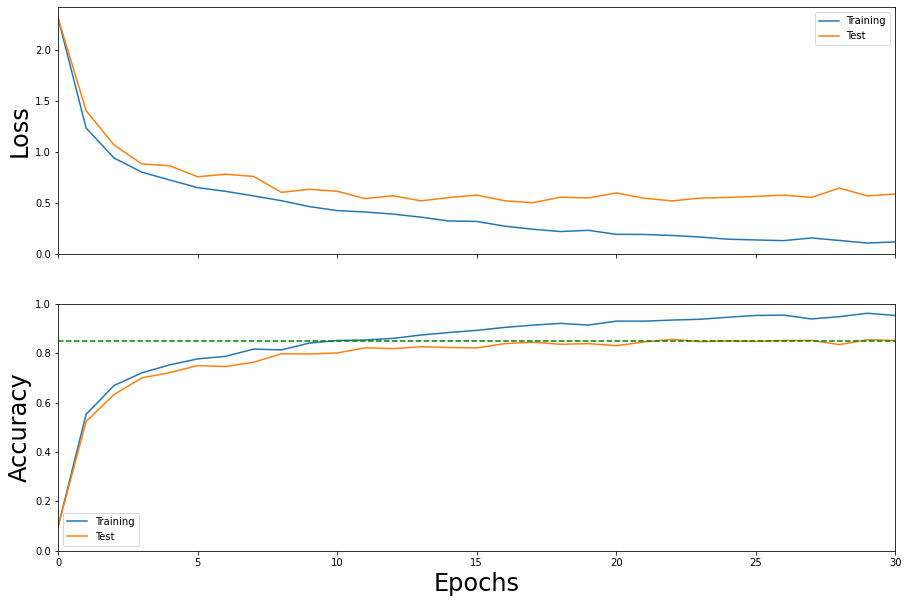

Epoch: __ 29
Train loss:  0.11919105
Test loss:  0.58812356
Train accuracy:  0.95241433
Test accuracy:  0.8512142
Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  4864      
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
residual_block (ResidualBloc multiple                  74368     
_________________________________________________________________
residual_block_1 (ResidualBl multiple                  74368     
_________________________________________________________________
residual_block_2 (ResidualBl multiple                  74368     
___________

In [30]:
%%time
tf.keras.backend.clear_session()

learning_rate = 0.001
epochs = 30

# Initialize the loss
loss_function = tf.keras.losses.CategoricalCrossentropy()

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize model
resnet_model = ResNet(blocks_per_scale=[3,5,3], start_filter=64, bottleneck = False, regularizer = None, dropout_rate = 0.3)
resnet_performance = train_model(
    model = resnet_model,
    train_dataset = train_dataset,
    test_dataset=test_dataset,
    num_epochs = epochs,
    loss_function = loss_function,
    optimizer = optimizer,
    learning_rate = learning_rate
)
resnet_model.summary()

# Define training and testing

We define our training and testing here again, because the autograph function of the tf.function decorator needs to regraph the function when we change anything about our model, but due to a bug the autograph doesn't run (see:https://github.com/tensorflow/tensorflow/issues/27120).  
While the 'solution' to redefine the functions isn't pretty, the only other solution would be to write a wrapper function around our functions to force a regraph in every call which would work against the increase in speed which was our reason to use tf.function in the first place.

(We just copied this cell so we can run the whole notebook at once.)

In [86]:
@tf.function
def train_step(model, input, target, loss_function, optimizer):
    with tf.GradientTape() as tape:
        prediction = model(input, training=True)
        loss = loss_function(target, prediction) + tf.reduce_sum(model.losses)        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(target, axis=1), tf.argmax(prediction, axis=1)),tf.float32))
    return loss, accuracy

@tf.function
def performance_calc(model, input, target, loss_function):
    prediction = model(input, training=False)
    loss = loss_function(target, prediction) + tf.reduce_sum(model.losses)
    accuracy =  tf.reduce_mean(tf.cast(tf.equal(tf.argmax(target, axis=1), tf.argmax(prediction, axis=1)),tf.float32))
    return loss, accuracy

def test(model, test_data, loss_function):
    # Test over complete test data
    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        loss, accuracy = performance_calc(model, input, target, loss_function)
        test_loss_aggregator.append(loss.numpy())
        test_accuracy_aggregator.append(accuracy.numpy())

    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

# Train DenseNet

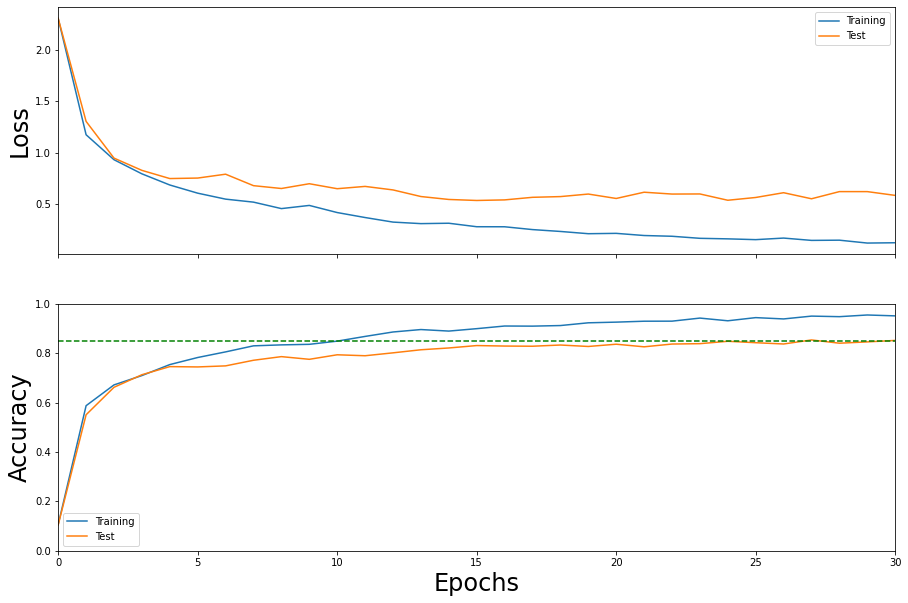

Epoch: __ 29
Train loss:  0.1256048
Test loss:  0.58562875
Train accuracy:  0.9507601
Test accuracy:  0.8514132
Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  2432      
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
dense_block (DenseBlock)     multiple                  62688     
_________________________________________________________________
transition_layer (Transition multiple                  12768     
_________________________________________________________________
dense_block_1 (DenseBlock)   multiple                  602784    
___________

In [87]:
%%time
tf.keras.backend.clear_session()

### Hyperparameters
learning_rate = 0.001
epochs = 30

# Initialize the loss
loss_function = tf.keras.losses.CategoricalCrossentropy()

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize model
densenet_model = DenseNet(layers_per_block=[6,18,12,6], growth_rate=16, regularizer = None, dropout_rate = 0.4)
densenet_performance = train_model(
    model = densenet_model,
    train_dataset = train_dataset,
    test_dataset=test_dataset,
    num_epochs = epochs,
    loss_function = loss_function,
    optimizer = optimizer,
    learning_rate = learning_rate
)
densenet_model.summary()

# Compare performance of our models

In [88]:
print(max(resnet_performance['test_accuracy']))
print(max(densenet_performance['test_accuracy']))

0.8553941
0.85330415


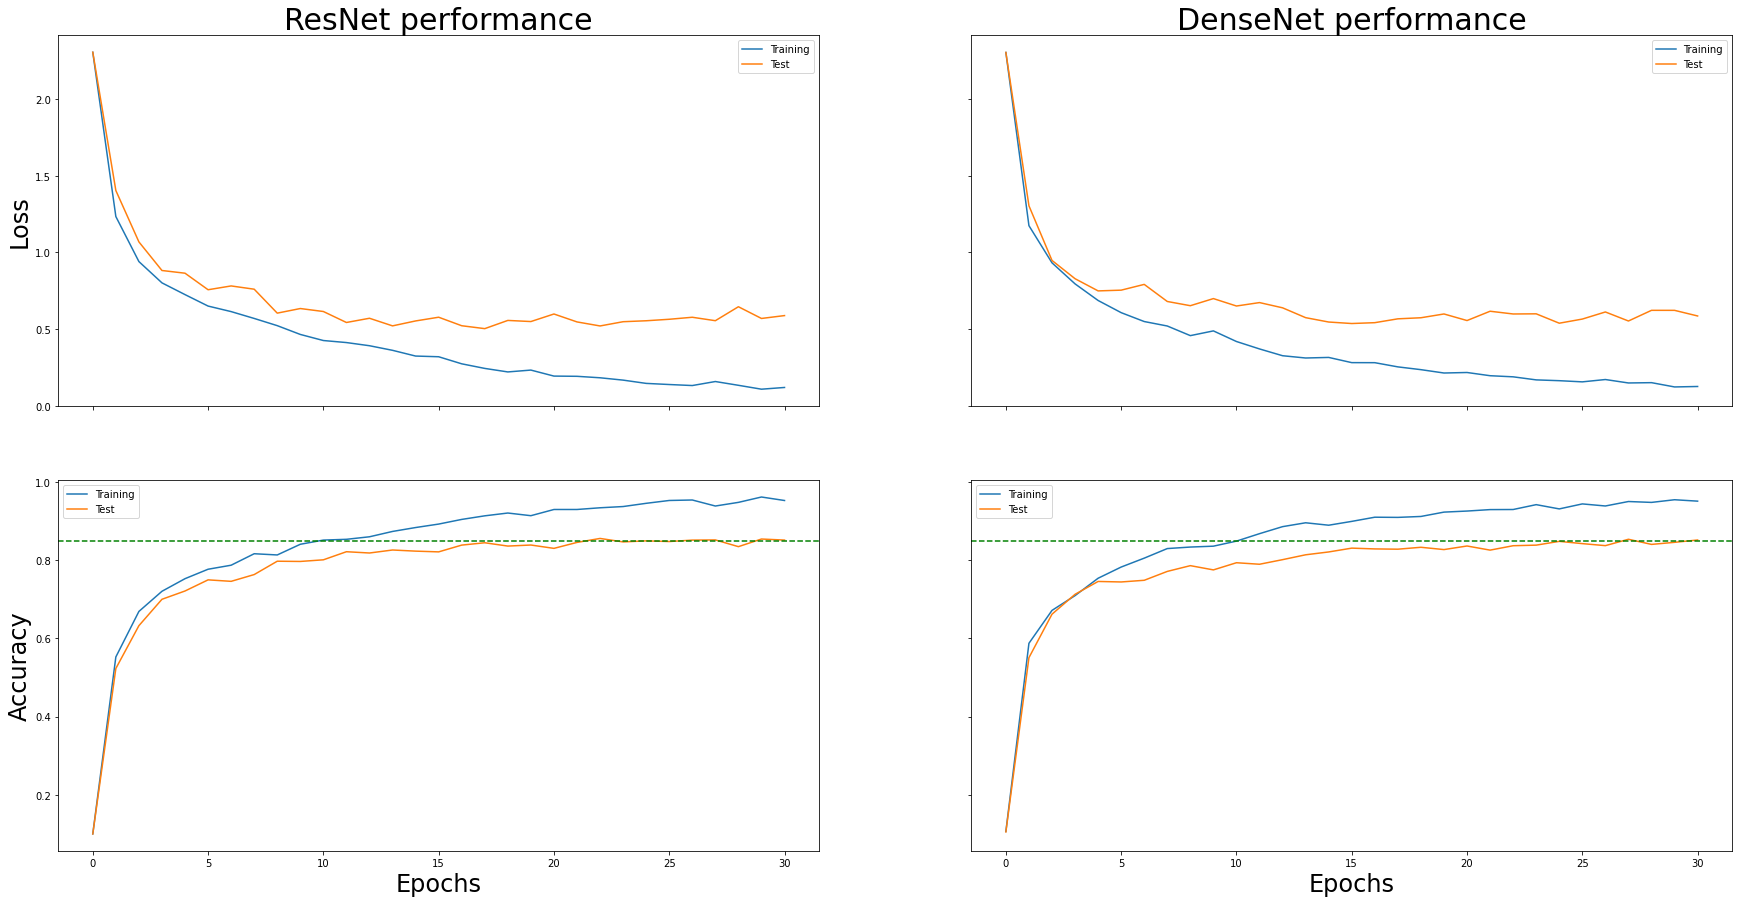

In [89]:
fig, ax = plt.subplots(2,2,sharex='col',sharey='row',figsize=(30,15))

ax[0,0].plot(resnet_performance['train_loss'],label="Training")
ax[0,0].plot(resnet_performance['test_loss'],label="Test")

ax[1,0].plot(resnet_performance['train_accuracy'],label="Training")
ax[1,0].plot(resnet_performance['test_accuracy'],label="Test")

ax[0,1].plot(densenet_performance['train_loss'],label="Training")
ax[0,1].plot(densenet_performance['test_loss'],label="Test")

ax[1,1].plot(densenet_performance['train_accuracy'],label="Training")
ax[1,1].plot(densenet_performance['test_accuracy'],label="Test")

fontsize=24
ax[0,0].set_title("ResNet performance",fontsize=30)
ax[0,1].set_title("DenseNet performance",fontsize=30)
ax[0,0].set_ylabel("Loss",fontsize=fontsize)
ax[1,0].set_ylabel("Accuracy",fontsize=fontsize)
ax[1,0].set_xlabel("Epochs",fontsize=fontsize)
ax[1,1].set_xlabel("Epochs",fontsize=fontsize)
ax[1,0].axhline(0.85,xmax=len(resnet_performance['train_accuracy']),c='g',ls='--')
ax[1,1].axhline(0.85,xmax=len(densenet_performance['train_accuracy']),c='g',ls='--')
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
plt.show()

When we compare our models the most significant difference to the plain CNN from last week is the training speed. Both ResNet and DenseNet can use a larger learning rate and can be trained much faster.  
When looking at the amount of parameters we need to get an accuracy of +85% we see that the DenseNet need way less parameters which again results in a even faster training in comparison to the ResNet.  
One thing we found interesting is that although it is controversial to use dropout layer in a CNN, we heavily rely on them to improve the generalization of our models. 